In [5]:
import numpy as np
import pandas as pd
import pytz
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load in the files

In [8]:
# Set display options
pd.set_option('display.max_columns', None)

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Master_Thesis/Data/timezone_prep.tsv', sep='\t')
timezones = pd.read_csv('/content/drive/MyDrive/Master_Thesis/Data/cohort_timezones.tsv', index_col="user_id", sep='\t')

## Identifying the users with a known timezone

In [10]:
# Store the users that have known timezones in a new variable
users_with_timezones = timezones[timezones['tz'].notna()][['tz']]
print("Number of users with timezones:", len(users_with_timezones))


Number of users with timezones: 676


In [ ]:
def convert_to_local_timezone(row):
    if pd.notna(row['tz']):
        try:
            # 'created_at' is UTC-aware, so directly convert to the given timezone
            return row['created_at'].tz_convert(row['tz'])
          except pytz.UnknownTimeZoneError:
            # Handle cases where the timezone string might be invalid, keep original
            return row['created_at']
    return row['created_at'] # If tz is NaN, keep original UTC datetime

In [12]:
# This function converts the created_at column according to the given timezone, if 'tz' is NaN, the original UTC is kept

def convert_to_local_timezone(row):
    if pd.notna(row['tz']):
            return row['created_at'].tz_convert(row['tz'])
    return row['created_at']

In [13]:
# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

In [15]:
# Apply the conversion to create a new column 'local_time
df['local_time'] = df.apply(convert_to_local_timezone, axis=1)



In [16]:
df.head()

,Unnamed: 0,tweet_id,user_id,created_at,tz,local_time
0,0,tD0731105,uDEP035,2020-07-06 13:57:01+00:00,America/Chicago,2020-07-06 08:57:01-05:00
1,1,tD0731106,uDEP035,2020-07-03 22:33:10+00:00,America/Chicago,2020-07-03 17:33:10-05:00
2,2,tD0731107,uDEP035,2020-07-03 22:21:46+00:00,America/Chicago,2020-07-03 17:21:46-05:00
3,3,tD0731108,uDEP035,2020-07-03 22:19:37+00:00,America/Chicago,2020-07-03 17:19:37-05:00
4,4,tD0731109,uDEP035,2020-06-27 08:58:03+00:00,America/Chicago,2020-06-27 03:58:03-05:00


### Drop the first two columns in the dataframe

The fase index column 'Unnamed: 0' has to be dropped

In [18]:
df = df.iloc[:, 1:]

## Create an hour variable

We need an hourly variable to bin and map with the known tz users.

In [19]:
df['created_at_hour'] = df['local_time'].apply(lambda x: x.hour if pd.notna(x) else np.nan)


Let's plot this for a random user to see if it worked.

The user that we're plotting created_at_hour frequency for: uANX757


/tmp/ipython-input-1944345966.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_frequency.index, y=hour_frequency.values, palette='viridis')


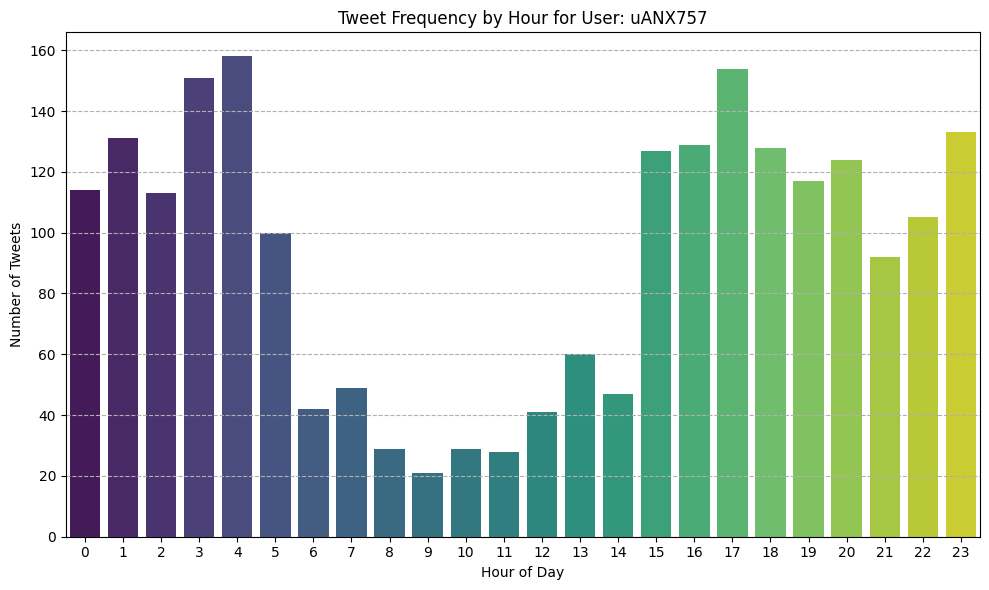

In [26]:
# Get a list of unique user_ids
unique_users = df['user_id'].unique()

# Select a random user_id
random_user_id = np.random.choice(unique_users)

print("The user that we're plotting created_at_hour frequency for:", random_user_id)

# Filter the DataFrame for the random user
user_data = df[df['user_id'] == random_user_id]

# Calculate the frequency of each created_at_hour
hour_frequency = user_data['created_at_hour'].value_counts().sort_index()

# Plot the frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=hour_frequency.index, y=hour_frequency.values, palette='viridis')
plt.title(f'Tweet Frequency by Hour for User: {random_user_id}')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tweets')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

As we can see, this circadian pattern is not aligned yet.

# Imputing the unknown timezones

We impute the unknown timezones by binning the hourly frequencies of all users and matching the patterns of unknown users to the known users.

## 1: Select only rows with a known timezone

In [27]:
df_with_known_tz = df[df['tz'].notna()]

## 2: Calculate aggregated hour frequency

Over all hours:

In [28]:
aggregated_hourly_frequency = df_with_known_tz['created_at_hour'].value_counts().sort_index()


Majority of tweets tweeted from Europe it seems.

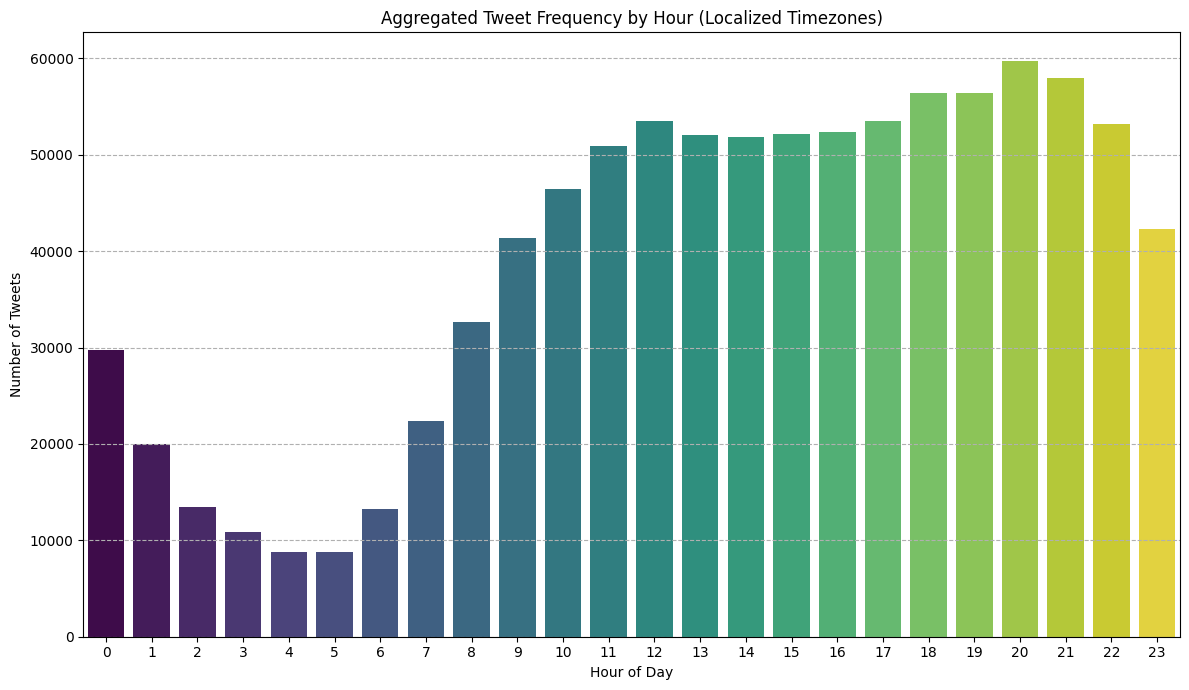

In [29]:
## LEt's plot this aggregated variable

plt.figure(figsize=(12, 7))
sns.barplot(x=aggregated_hourly_frequency.index, y=aggregated_hourly_frequency.values, palette='viridis', hue=aggregated_hourly_frequency.index, legend=False)
plt.title('Aggregated Tweet Frequency by Hour (Localized Timezones)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tweets')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## 3: Characterize hourly patterns by known timezones

In [30]:
# Calculate tweet count per timezone per hour
hourly_tweet_counts = df_with_known_tz.groupby(['tz', 'created_at_hour']).size().reset_index(name='tweet_count')

To normalise hourly tweet frequencies, we need to calculate the total number of tweets for each timzone

In [31]:
total_tweets_per_timezone = df_with_known_tz.groupby('tz').size().reset_index(name='total_tweets')

Normalize the frequencies to account for total number of tweets per timezone (not many people in Cairo)

In [32]:
normalized_hourly_frequency = pd.merge(hourly_tweet_counts, total_tweets_per_timezone, on='tz')
normalized_hourly_frequency['normalized_frequency'] = normalized_hourly_frequency['tweet_count'] / normalized_hourly_frequency['total_tweets']

Let's visualise this!

/tmp/ipython-input-3795491501.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


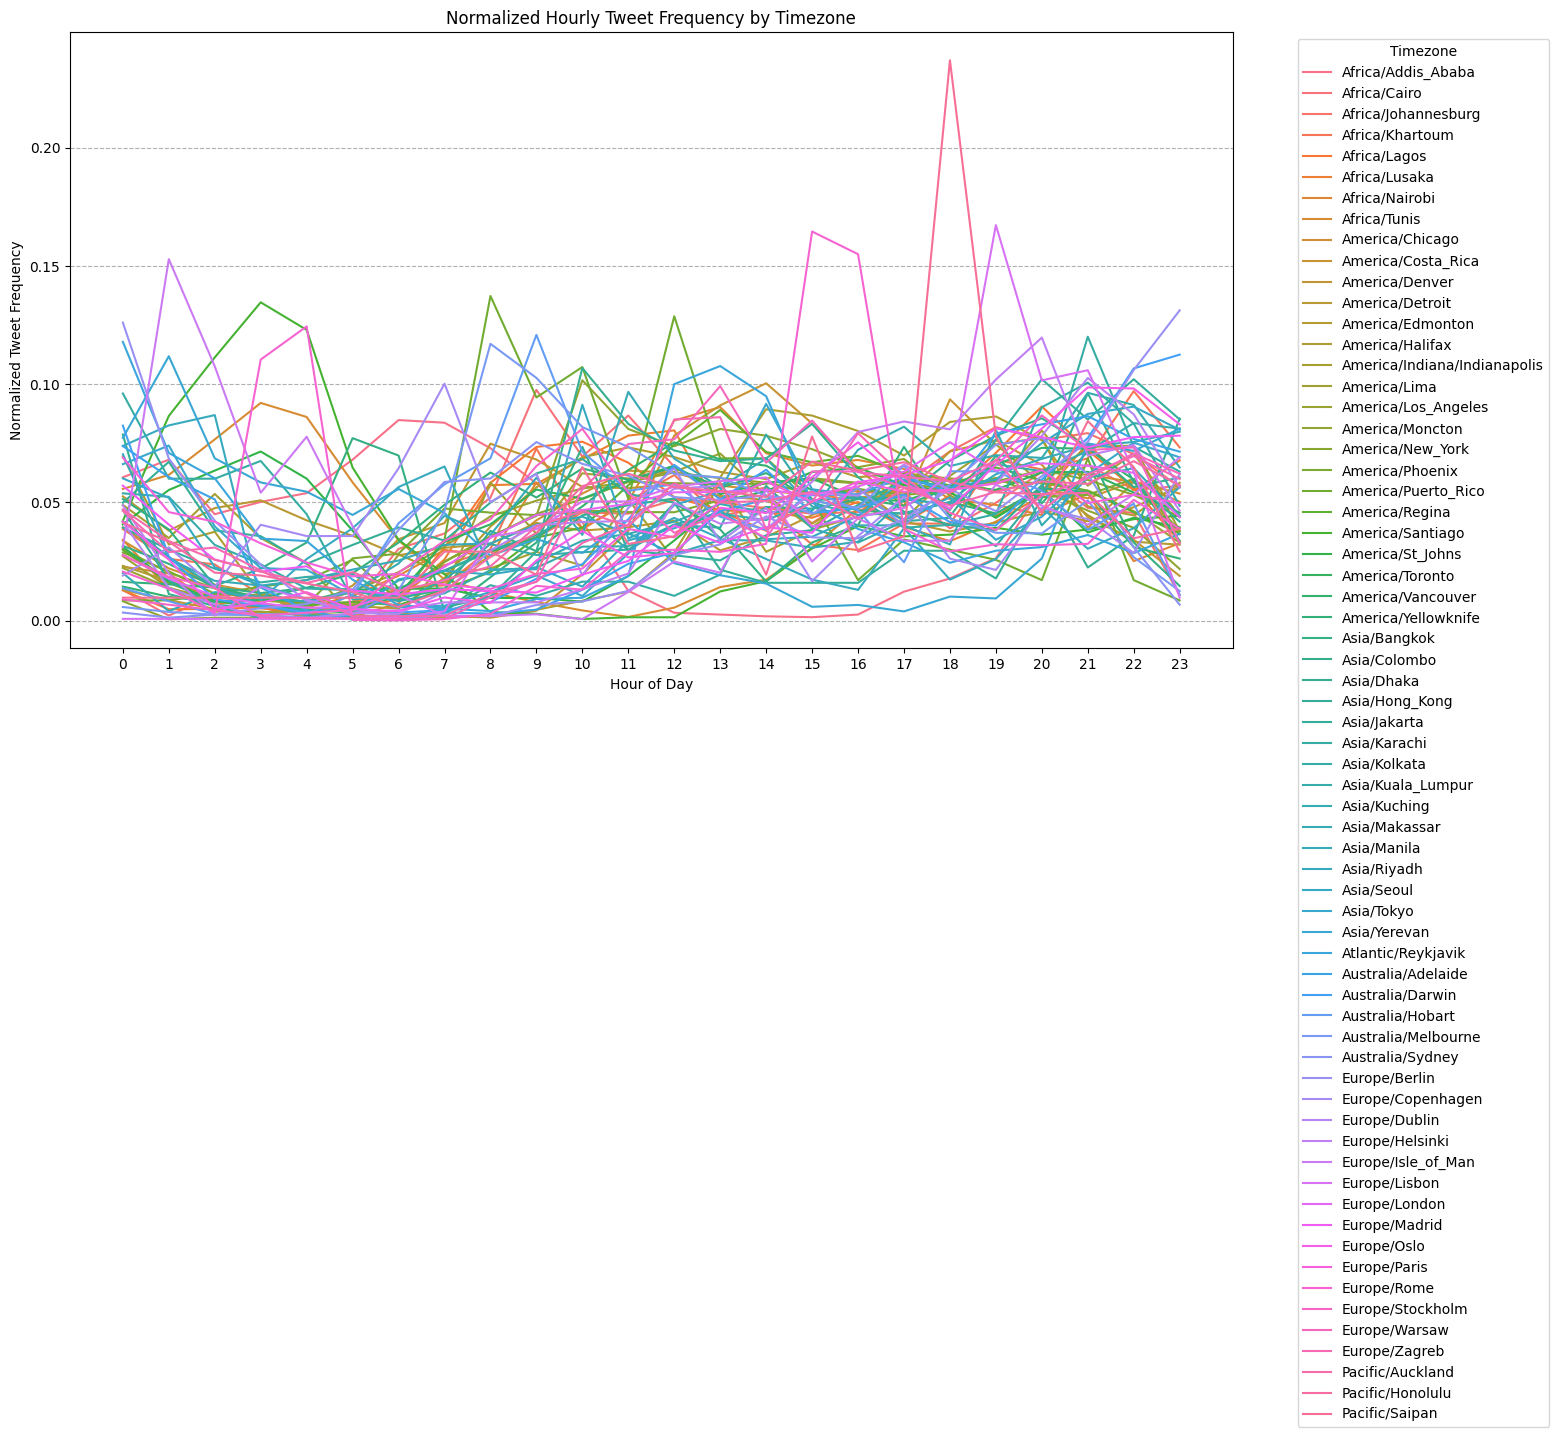

In [33]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='created_at_hour', y='normalized_frequency', hue='tz', data=normalized_hourly_frequency)
plt.title('Normalized Hourly Tweet Frequency by Timezone')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Tweet Frequency')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.legend(title='Timezone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Wow!

## 4: Identify users with missing timezones and repeat steps 2 and 3 for this group

In [35]:
# Create a new dataframe containing only the user_ids from df where the tz column is NaN

users_without_tz = df[df['tz'].isna()]['user_id'].unique()

Calculate individual hourly patterns for unknown users using their current UTC

In [36]:
df_without_tz = df[df['user_id'].isin(users_without_tz)].copy()

Next: get the hour component, just like the known tz group

In [37]:
df_without_tz['created_at_hour'] = df_without_tz['local_time'].apply(lambda x: x.hour)

Group the without timezone dataframe by user_id and created_at_hour to count the number of tweets for each combination.

In [38]:
individual_hourly_counts = df_without_tz.groupby(['user_id', 'created_at_hour']).size().reset_index(name='tweet_count')


Now group the df without timezones by user_id and count the tweets

In [39]:
total_tweets_per_unknown_user = df_without_tz.groupby('user_id').size().reset_index(name='total_tweets')


###Let's normalize again!

First: merge the individual hourly counts with total tweets per unknown user on user_id.

In [40]:
individual_normalized_hourly_frequency = pd.merge(individual_hourly_counts, total_tweets_per_unknown_user, on='user_id')

Now, we normalize.

In [41]:
individual_normalized_hourly_frequency['normalized_frequency'] = individual_normalized_hourly_frequency['tweet_count'] / individual_normalized_hourly_frequency['total_tweets']

## 5: Implement Timezone inference logic

First, the DataFrame needs to be pivoted into a wide format. 'TZ' will become the index, the 'hour' features the columns and 'normalized_frequency' the values.

Then, any NaN values are filled with 0.

In [42]:
normalized_timezone_patterns = normalized_hourly_frequency.pivot_table(index='tz', columns='created_at_hour', values='normalized_frequency').fillna(0)

Now we do the same with the unknown timezone users, but we pivot on 'user_id' instead of tz.

In [43]:
individual_user_patterns = individual_normalized_hourly_frequency.pivot_table(index='user_id', columns='created_at_hour', values='normalized_frequency').fillna(0)

## 6: Calculate cosine similarity and infer unknown timezones

In [45]:
# 1. convert relevant DataFrames to numpy arrays
user_patterns_array = individual_user_patterns.values
timezone_patterns_array = normalized_timezone_patterns.values

# 2. Calculate cosine similarity, users will be rows and timezone patterns willl be columns
similarity_matrix = cosine_similarity(user_patterns_array, timezone_patterns_array)

# 3. Find the index of the best matching timezone for each user
best_match_indices = np.argmax(similarity_matrix, axis=1)

# Map these indices back to the actual timezone names and store in a series
inferred_timezones = pd.Series(
    normalized_timezone_patterns.index[best_match_indices],
    index=individual_user_patterns.index,
    name='inferred_timezone'
)

## 7: Now we impute

In [46]:
# Update the 'tz' column in df using the inferred timezones
df['tz'] = df['tz'].fillna(df['user_id'].map(inferred_timezones))

# Check if there are any remaining NaN values in 'tz'
print("Number of NaN values in 'tz' after imputation:", df['tz'].isna().sum())


Number of NaN values in 'tz' after imputation: 0


## 8: Get correct hour, week and date variables

In [47]:
# Re-apply the conversion to update 'local_time' based on the newly imputed 'tz' values
df['local_time'] = df.apply(convert_to_local_timezone, axis=1)

Update created_at_hour

In [48]:
df['created_at_hour'] = df['local_time'].apply(lambda x: x.hour if pd.notna(x) else np.nan)

One-hot encode created_at_hour

In [51]:
one_hot_encoded_hours = pd.get_dummies(df['created_at_hour'], prefix='hour')

# Merge these back into the original DataFrame
df = pd.concat([df, one_hot_encoded_hours], axis=1)

Create day of the week feature

In [52]:
df['day_of_week'] = df['local_time'].apply(lambda x: x.dayofweek if pd.notna(x) else np.nan)


In [56]:
# Define a mapping for day numbers to day names
day_names_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Create a new column with day names
df['day_of_week_name'] = df['day_of_week'].map(day_names_map)

# Create one-hot encoded variables for day of week using the names
one_hot_encoded_days = pd.get_dummies(df['day_of_week_name'], prefix='day')

# Concatenate these new columns back to the original DataFrame
df = pd.concat([df, one_hot_encoded_days], axis=1)

In [57]:
df.head()

,user_id,created_at,tz,local_time,created_at_hour,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week,day_of_week_name,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,uDEP035,2020-07-06 13:57:01+00:00,America/Chicago,2020-07-06 08:57:01-05:00,8,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,Monday,False,True,False,False,False,False,False
1,uDEP035,2020-07-03 22:33:10+00:00,America/Chicago,2020-07-03 17:33:10-05:00,17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4,Friday,True,False,False,False,False,False,False
2,uDEP035,2020-07-03 22:21:46+00:00,America/Chicago,2020-07-03 17:21:46-05:00,17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4,Friday,True,False,False,False,False,False,False
3,uDEP035,2020-07-03 22:19:37+00:00,America/Chicago,2020-07-03 17:19:37-05:00,17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,4,Friday,True,False,False,False,False,False,False
4,uDEP035,2020-06-27 08:58:03+00:00,America/Chicago,2020-06-27 03:58:03-05:00,3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5,Saturday,False,False,True,False,False,False,False


Add Date column

In [59]:
df['local_date'] = df['local_time'].apply(lambda x: x.date() if pd.notna(x) else np.nan)


## 9: Save DataFrame

In [ ]:
df.to_csv('/content/drive/MyDrive/Master_Thesis/Data/timezones_imputed_complete.tsv', sep='\t')